<a href="https://colab.research.google.com/github/dani-lbnl/mudit/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import packages

In [1]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import Select
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import gensim
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def get_driver():
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument("--disable-infobars")
  # open it, go to a website, and get results
  wd = webdriver.Chrome('chromedriver',options=options)
  return wd

### import and process data from pubs.xlsx

In [5]:
def preprocess_lda(data):
  stop_words = stopwords.words('english')

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  data_words_nostops = remove_stopwords(data)

  # Create Dictionary 
  id2word = corpora.Dictionary(data_words_nostops)  
  # Create Corpus 
  texts = data_words_nostops  
  # Term Document Frequency 
  corpus = [id2word.doc2bow(text) for text in texts]  

  words = []
  for word in texts:
    words.extend(word)

  return corpus, id2word, words

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
df = pd.read_table('/content/drive/MyDrive/LBNL/Pubs.xls')
abstracts = list(df[~df['Abstract'].isna()]['Abstract'])

corpus_abs, id2word_abs, words_abs = preprocess_lda(abstracts)

### Word2Vec model for something

In [14]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('drive/MyDrive/LBNL/GoogleNews-vectors-negative300.bin', binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
vector.shape

(300,)

### using similarity for something

In [15]:
def get_sim(num_topics):

  # create lda model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                            id2word=id2word_abs,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  # initialise similarity list 
  similarity_list = []

  for i in range(num_topics):
    terms_1 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(i)]
    for j in range(i,num_topics):
      terms_2 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(j)]
      cs = 0
      count = 0
      # print(terms_1, terms_2)
      for val1 in terms_1:
        for val2 in terms_2:
          # print(val1,val2)
          if(val1 in model and val2 in model):
            count += 1
            cs += cosine_similarity(model[[val1]],model[[val2]])[0][0]
      cs = cs/count
      similarity_list.append(cs)
      # print(count)

  return np.array(similarity_list).mean()

x = range(5,50,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

0.14347996662630855
0.1331232863701999
0.1282598894481103
0.12348910123845083
0.1222129035972635
0.12174680032493819
0.124699498956117
0.11900004271030581
0.11862458619543913


Text(0, 0.5, 'Topic similarity (Cosine)')

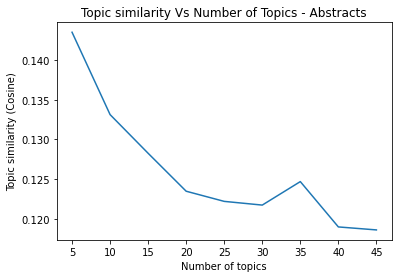

In [16]:
plt.plot(x,topic_sim_num)
plt.title("Topic similarity Vs Number of Topics - Abstracts")
plt.xlabel("Number of topics")
plt.ylabel("Topic similarity (Cosine)")

#### Iteration 1 - on just abstract

In [17]:
lda_model_abs = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                           id2word=id2word_abs,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
for i in range(25):
  terms = lda_model_abs.get_topic_terms(i)
  print([id2word_abs[term[0]] for term in terms])

['scaffolds', 'ash', 'conversion', 'fuel', 'char', 'mechanical', 'properties', 'formation', 'new', 'fuels']
['sup', 'phase', 'ray', 'eruption', 'using', 'rate', 'plant', 'samples', 'pumice', 'may']
['bone', 'water', 'starch', 'collagen', 'mass', 'hydraulic', 'bark', 'flowers', 'xylem', 'ray']
['ray', 'ct', 'high', 'study', 'tomography', 'three', 'cement', 'fiber', 'cracks', 'evolution']
['vessel', 'flow', 'xylem', 'vessels', 'water', 'transport', 'connections', 'roots', 'dm', 'sap']
['flow', 'water', 'hydraulic', 'sup', 'root', 'function', 'matrix', 'properties', 'tissue', 'conductivity']
['sup', 'inf', 'columns', 'nb', 'calcite', 'fe', 'zr', 'solutions', 'performance', 'experiments']
['inf', 'rates', 'surface', 'carbonate', 'data', 'ray', 'experiments', 'wall', 'based', 'model']
['bone', 'scales', 'collagen', 'fracture', 'electrode', 'structural', 'ray', 'changes', 'structure', 'resistance']
['inf', 'sup', 'leaf', 'high', 'xylem', 'ias', 'water', 'pore', 'hydraulic', 'conductivity']
[

#### Iteration 2 - on combined title and abstract

In [22]:
# set all nulls to blanks - not sure of the reason?

# for title
indices = df['Title'].isna()
df.loc[indices,'Title'] = ""

# for abstract
indices = df['Abstract'].isna()
df.loc[indices,'Abstract'] = ""

# combined - title + abstract
df['Combined'] = df['Title'] + " " + df['Abstract']
combined = list(df['Combined'])

In [23]:
# lda on combined data (title + abstract)

corpus_comb, id2word_comb, words_comb = preprocess_lda(combined)

lda_model_comb = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                           id2word=id2word_comb,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
lda_model_comb.get_topic_terms(0)

[(818, 0.026201189),
 (1051, 0.020536674),
 (387, 0.01201322),
 (6, 0.011775383),
 (381, 0.010277768),
 (8, 0.009944911),
 (380, 0.00915525),
 (1063, 0.008562411),
 (1056, 0.0084965965),
 (759, 0.008154762)]

In [29]:
# print words 

for i in range(25):
  terms = lda_model_comb.get_topic_terms(i)
  print(terms)
  print([id2word_comb[term[0]] for term in terms])

[(818, 0.026201189), (1051, 0.020536674), (387, 0.01201322), (6, 0.011775383), (381, 0.010277768), (8, 0.009944911), (380, 0.00915525), (1063, 0.008562411), (1056, 0.0084965965), (759, 0.008154762)]
['water', 'transport', 'scale', 'ray', 'porous', 'tomography', 'pore', 'layers', 'gas', 'diffusion']
[(1532, 0.023579532), (1539, 0.0122423535), (1533, 0.011625821), (1518, 0.011477367), (8, 0.009666413), (6, 0.009347822), (2013, 0.0087080505), (81, 0.00820299), (1526, 0.006801184), (818, 0.00627637)]
['vessel', 'xylem', 'vessels', 'plant', 'tomography', 'ray', 'connections', 'using', 'species', 'water']
[(1285, 0.019892845), (16, 0.019068342), (846, 0.012227126), (1600, 0.010997915), (6063, 0.008838116), (5644, 0.008160315), (380, 0.008160152), (1243, 0.008160045), (391, 0.007559782), (1525, 0.0075135515)]
['scaffolds', 'bone', 'inf', 'glass', 'nb', 'zr', 'pore', 'bioactive', 'structures', 'repair']
[(564, 0.012848501), (571, 0.009710371), (44, 0.008574149), (466, 0.008296015), (324, 0.007